In [1]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=db8604712035b324d86081a1e2293c5d2d4912b70f6d4093d2599e856ba577a4
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN

Using TensorFlow backend.


In [0]:
%config InlineBackend.figure_format = 'retina'

In [0]:
start_date = '2016-02-01'
end_date = '2019-12-31'

In [5]:
data = yfinance.download("AUDUSD=X CADUSD=X CHFUSD=X \
                          CNYUSD=X DKKUSD=X EURUSD=X \
                          GBPUSD=X HKDUSD=X JPYUSD=X \
                          KZTUSD=X NOKUSD=X NZDUSD=X \
                          PLNUSD=X RUBUSD=X SEKUSD=X",
                        start=start_date, end=end_date)

[*********************100%***********************]  15 of 15 completed


In [6]:
data['Close'].head()

AUDUSD=X  CADUSD=X  CHFUSD=X  ...  PLNUSD=X  RUBUSD=X  SEKUSD=X
Date                                      ...                              
2016-02-01  0.706864  0.715676  0.976086  ...  0.245228  0.013256  0.116426
2016-02-02  0.711086  0.716846  0.980873  ...  0.247986  0.012943  0.117306
2016-02-03  0.702988  0.711238  0.981653  ...  0.248004  0.012545  0.116964
2016-02-04  0.715461  0.724942  0.994827  ...  0.251062  0.012999  0.118491
2016-02-05  0.719942  0.726998  1.006654  ...  0.253291  0.013026  0.119067

[5 rows x 15 columns]

In [7]:
data['Close'].describe()

AUDUSD=X     CADUSD=X  ...     RUBUSD=X     SEKUSD=X
count  1019.000000  1019.000000  ...  1019.000000  1019.000000
mean      0.739233     0.764229  ...     0.015967     0.113791
std       0.033680     0.019115  ...     0.001051     0.006508
min       0.670808     0.711238  ...     0.012536     0.100556
25%       0.712078     0.751233  ...     0.015258     0.108809
50%       0.744879     0.761087  ...     0.015713     0.113203
75%       0.764030     0.775518  ...     0.016910     0.119123
max       0.811688     0.825948  ...     0.017976     0.127521

[8 rows x 15 columns]

In [0]:
new_data = data['Close'].interpolate(method='polynomial', order=3)

In [9]:
new_data.describe()

AUDUSD=X     CADUSD=X  ...     RUBUSD=X     SEKUSD=X
count  1019.000000  1019.000000  ...  1019.000000  1019.000000
mean      0.739233     0.764229  ...     0.015967     0.113791
std       0.033680     0.019115  ...     0.001051     0.006508
min       0.670808     0.711238  ...     0.012536     0.100556
25%       0.712078     0.751233  ...     0.015258     0.108809
50%       0.744879     0.761087  ...     0.015713     0.113203
75%       0.764030     0.775518  ...     0.016910     0.119123
max       0.811688     0.825948  ...     0.017976     0.127521

[8 rows x 15 columns]

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
 new_data['day'] = new_data.index.day
 new_data['month'] = new_data.index.month

In [12]:
values = new_data.values
values

array([[ 0.70686364,  0.71567619,  0.9760859 , ...,  0.11642582,
         1.        ,  2.        ],
       [ 0.71108586,  0.71684587,  0.98087299, ...,  0.11730605,
         2.        ,  2.        ],
       [ 0.70298767,  0.71123755,  0.98165292, ...,  0.1169644 ,
         3.        ,  2.        ],
       ...,
       [ 0.69463742,  0.7628929 ,  1.01887989, ...,  0.10633377,
        27.        , 12.        ],
       [ 0.69829965,  0.76491195,  1.02699983, ...,  0.10722665,
        30.        , 12.        ],
       [ 0.70013791,  0.76566166,  1.03238595, ...,  0.10701276,
        31.        , 12.        ]])

In [13]:
values.shape

(1019, 17)

In [0]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [15]:
scaled

array([[0.25593185, 0.0386939 , 0.0439291 , ..., 0.5885236 , 0.        ,
        0.09090909],
       [0.28590202, 0.04889107, 0.0861063 , ..., 0.62116647, 0.03333334,
        0.09090909],
       [0.2284193 , 0.        , 0.09297752, ..., 0.6084964 , 0.06666668,
        0.09090909],
       ...,
       [0.16914749, 0.4503107 , 0.42097282, ..., 0.21426368, 0.8666667 ,
        1.        ],
       [0.19514275, 0.46791172, 0.4925146 , ..., 0.24737573, 0.96666664,
        1.        ],
       [0.2081914 , 0.47444773, 0.5399704 , ..., 0.23944402, 1.0000001 ,
        1.        ]], dtype=float32)

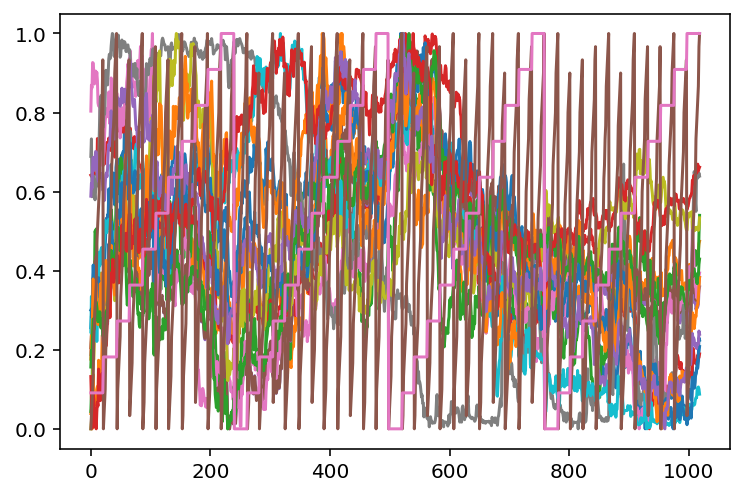

In [16]:
plt.plot(scaled)
plt.show()

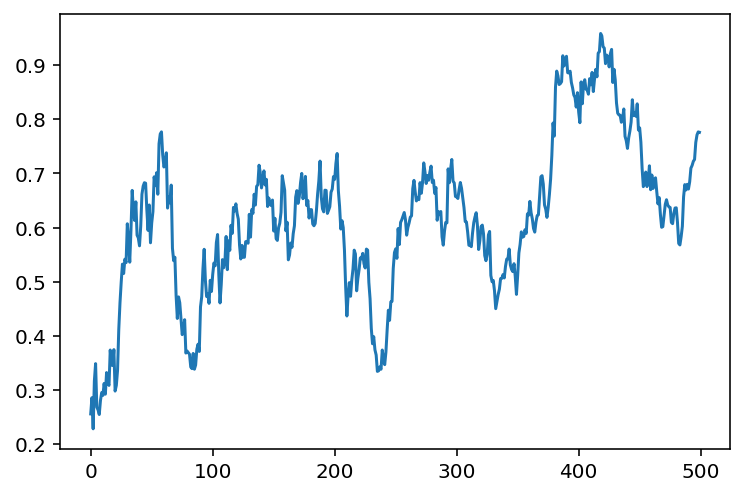

In [17]:
plt.plot(scaled[:,0][0:500])

In [18]:
# specify the number of lag hours
n_hours = 30
n_features = scaled.shape[1]
n_predict = 1
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_predict)
print(reframed.shape)

(989, 527)


In [19]:
reframed.head()

var1(t-30)  var2(t-30)  var3(t-30)  ...  var15(t)  var16(t)  var17(t)
30    0.255932    0.038694    0.043929  ...  0.720021  0.433333  0.181818
31    0.285902    0.048891    0.086106  ...  0.714828  0.466667  0.181818
32    0.228419    0.000000    0.092978  ...  0.729730  0.500000  0.181818
33    0.316959    0.119473    0.209049  ...  0.775615  0.533333  0.181818
34    0.348768    0.137392    0.313253  ...  0.804267  0.566667  0.181818

[5 rows x 527 columns]

In [0]:
# split into train and test sets
values = reframed.values
n_train_hours = 500
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [0]:
# split into input and outputs
n_obs = n_hours * n_features

In [22]:
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print(train_X.shape, train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(500, 510) (500, 17)
(500, 30, 17) (500, 17) (489, 30, 17) (489, 17)


In [23]:
train_X[0]

array([[0.25593185, 0.0386939 , 0.0439291 , 0.64156723, 0.18777752,
        0.20543861, 0.8036547 , 0.68912506, 0.        , 0.24512935,
        0.30025148, 0.1762433 , 0.15635943, 0.1321969 , 0.5885236 ,
        0.        , 0.09090909],
       [0.28590202, 0.04889107, 0.0861063 , 0.63893175, 0.22134686,
        0.23911333, 0.86938477, 0.7333145 , 0.01928616, 0.3348639 ,
        0.30319977, 0.23539543, 0.19794154, 0.07479477, 0.62116647,
        0.03333334, 0.09090909],
       [0.2284193 , 0.        , 0.09297752, 0.6373286 , 0.23259163,
        0.25079298, 0.8626237 , 0.5869827 , 0.05771112, 0.15758896,
        0.28015852, 0.21541405, 0.19821048, 0.00151777, 0.6084964 ,
        0.06666668, 0.09090909],
       [0.3169589 , 0.1194725 , 0.20904922, 0.64053583, 0.31331444,
        0.33052063, 0.9264169 , 0.6046219 , 0.1270628 , 0.27230763,
        0.37307405, 0.31450033, 0.24432397, 0.08500123, 0.66509414,
        0.10000001, 0.09090909],
       [0.34876776, 0.13739157, 0.3132534 , 0.654541

In [24]:
train_y[0]

array([0.6069503 , 0.38614464, 0.40973663, 0.7353339 , 0.35148287,
       0.36681175, 0.8520665 , 0.9360504 , 0.30978966, 0.5302913 ,
       0.46760988, 0.38757133, 0.3826518 , 0.3251357 , 0.72002053,
       0.43333337, 0.18181819], dtype=float32)

In [25]:
values[:,0][0:n_hours+n_predict]

array([0.25593185, 0.28590202, 0.2284193 , 0.3169589 , 0.34876776,
       0.26837587, 0.26339102, 0.25486803, 0.28088236, 0.2952509 ,
       0.29021263, 0.31223917, 0.2923708 , 0.33226538, 0.31369066,
       0.30861568, 0.37390852, 0.3461938 , 0.3454585 , 0.3746519 ,
       0.2981348 , 0.30861568, 0.33628893, 0.41171074, 0.46119356,
       0.49924374, 0.5324764 , 0.51516104, 0.5415735 , 0.5352416 ,
       0.6069503 ], dtype=float32)

Train on 500 samples, validate on 489 samples
Epoch 1/100
 - 2s - loss: 0.3326 - val_loss: 0.1703
Epoch 2/100
 - 1s - loss: 0.2218 - val_loss: 0.1104
Epoch 3/100
 - 1s - loss: 0.1204 - val_loss: 0.0707
Epoch 4/100
 - 1s - loss: 0.0622 - val_loss: 0.0843
Epoch 5/100
 - 1s - loss: 0.0524 - val_loss: 0.0595
Epoch 6/100
 - 1s - loss: 0.0400 - val_loss: 0.0468
Epoch 7/100
 - 1s - loss: 0.0409 - val_loss: 0.0443
Epoch 8/100
 - 1s - loss: 0.0384 - val_loss: 0.0453
Epoch 9/100
 - 1s - loss: 0.0345 - val_loss: 0.0499
Epoch 10/100
 - 1s - loss: 0.0335 - val_loss: 0.0514
Epoch 11/100
 - 1s - loss: 0.0317 - val_loss: 0.0477
Epoch 12/100
 - 1s - loss: 0.0294 - val_loss: 0.0443
Epoch 13/100
 - 1s - loss: 0.0275 - val_loss: 0.0422
Epoch 14/100
 - 1s - loss: 0.0256 - val_loss: 0.0415
Epoch 15/100
 - 1s - loss: 0.0242 - val_loss: 0.0405
Epoch 16/100
 - 1s - loss: 0.0228 - val_loss: 0.0387
Epoch 17/100
 - 1s - loss: 0.0214 - val_loss: 0.0373
Epoch 18/100
 - 1s - loss: 0.0202 - val_loss: 0.0366
Epoch 19/

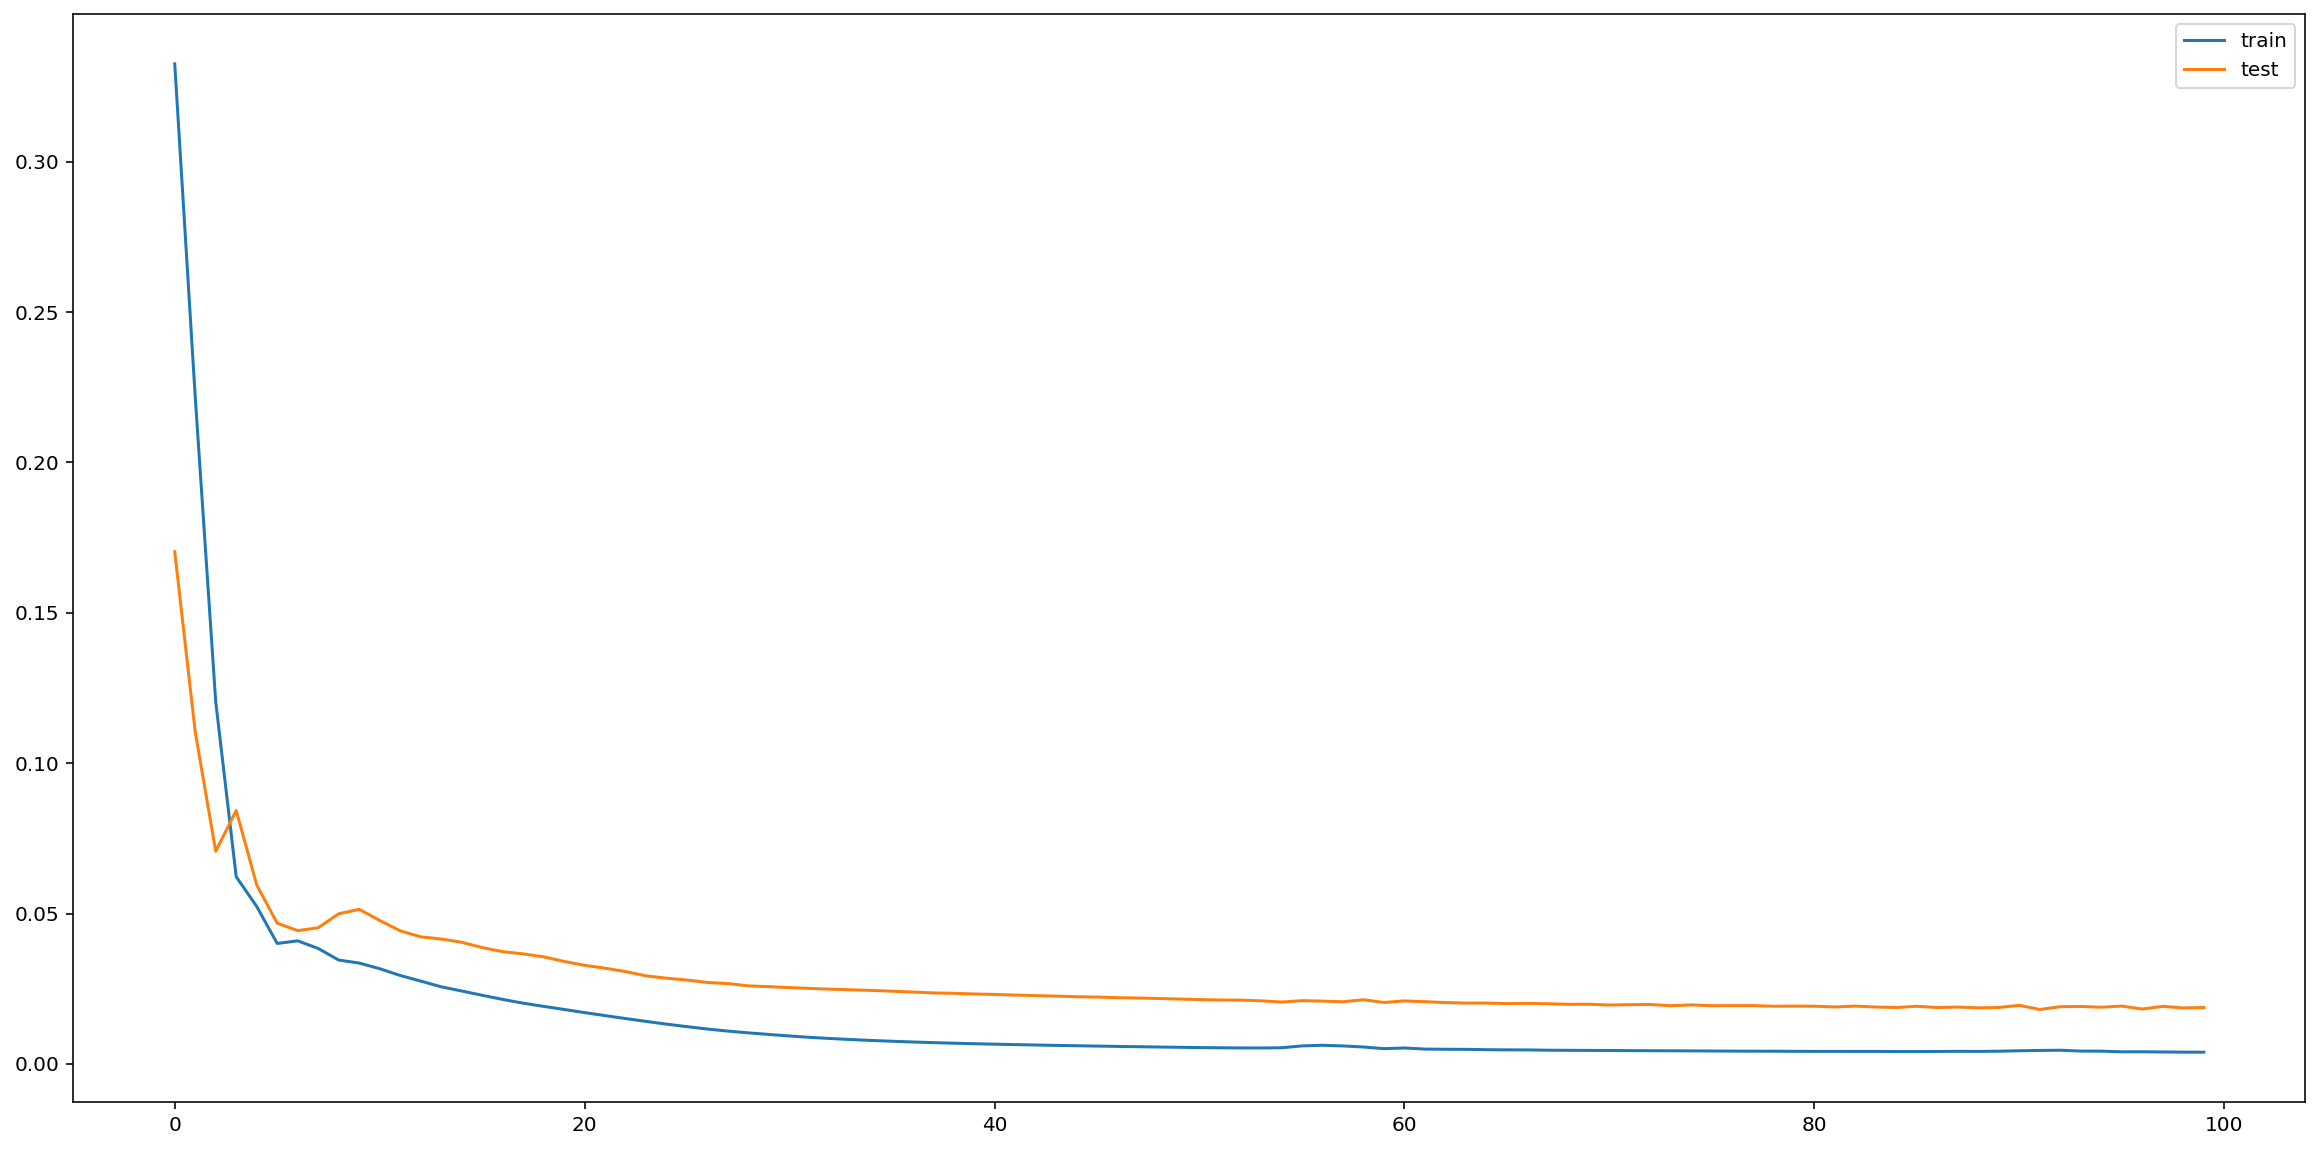

In [26]:
# design network
model = Sequential()
model.add(GRU(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, activation='relu'))
model.add(GRU(128, return_sequences=False, activation='relu'))
model.add(Dense(train_y.shape[1], activation='linear'))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
fig, ax = plt.subplots(figsize=(20,10))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
y_hat = scaler.inverse_transform(test_y)
y_pred = scaler.inverse_transform(model.predict(test_X))

In [28]:
for i in range(n_features):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(y_hat[:, i], color='green')
    plt.plot(y_pred[:, i], color='red')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
def predict(start_arr, dist):
    res = np.array(start_arr)[:,0:n_features]
    
    for i in range(dist):
        pred = model.predict(np.array([res[-n_hours:]])).reshape(n_predict,n_features)
        res = np.concatenate((res, pred))
        if len(res) > dist + len(start_arr):
            break
    
    return res

In [30]:
for i in range(n_features):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(scaler.inverse_transform(test_y[:,0:n_features])[:,i], color='green')
    plt.plot(scaler.inverse_transform(predict(train_y, len(test_y))[500:500+len(test_y)])[:,i], color='red')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

RMSE:

In [33]:
np.square(y_hat - y_pred).mean(axis = 0)

array([6.4067211e-04, 1.5048361e-04, 2.5867848e-04, 7.3950168e-06,
       2.6227360e-06, 7.8545097e-05, 2.2331892e-04, 7.3462722e-08,
       5.9570340e-08, 2.5171467e-08, 4.9584460e-06, 2.2122065e-04,
       2.1015381e-05, 2.9082724e-07, 2.5970854e-05, 4.3494625e+01,
       8.0576372e-01], dtype=float32)

In [32]:
np.square(scaler.inverse_transform(test_y[:,0:n_features]) - scaler.inverse_transform(predict(train_y, len(test_y))[500:500+len(test_y)])).mean(axis=0)

array([6.35383511e-03, 1.44708820e-03, 2.23890739e-03, 1.09683955e-04,
       8.30925419e-05, 4.23991028e-03, 1.50452517e-02, 3.93337785e-07,
       3.46523450e-08, 1.33926434e-07, 1.04848135e-04, 2.78680702e-03,
       4.36007889e-04, 2.23619509e-06, 2.65485112e-04, 7.70694656e+01,
       6.86892929e+01], dtype=float32)